In [6]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mlxtend.preprocessing import minmax_scaling

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# Load the training data
train = pd.read_csv("../data/original/train.csv", index_col=0)
test = pd.read_csv("../data/original/test.csv", index_col=0)

# Preview the data
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [4]:
# カテゴリ変数と数値変数を抜き出せるようにする
cat_features = ["cat" + str(i) for i in range(10)]
num_features = ["cont" + str(i) for i in range(14)]

In [7]:
# Separate target from features
y = train['target']
features = train.drop(['target'], axis=1)

# List of features for later use
feature_list = list(features.columns)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [8]:
# ordinal-encode categorical columns
X = features.copy()
X_test = test.copy()

# ordinal encode input variables
ordinal_encoder = OrdinalEncoder()
X[cat_features] = ordinal_encoder.fit_transform(features[cat_features])
X_test[cat_features] = ordinal_encoder.transform(test[cat_features])

# Preview the ordinal-encoded features
X.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2)

In [10]:
# Define the model 
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
# Train the model
model_rf.fit(X_train, y_train)
preds_valid = model_rf.predict(X_valid)
print(mean_squared_error(y_valid, preds_valid, squared=False))

0.7314724629930255


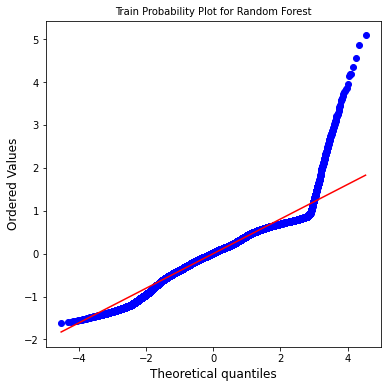

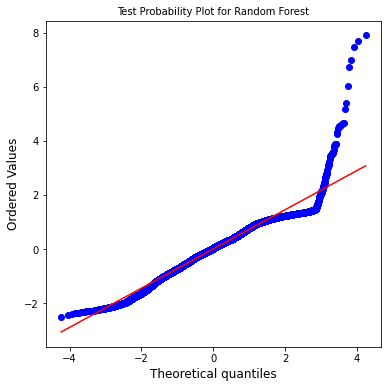

In [11]:
plt.rcParams["axes.labelsize"] = 12
rf_prob_train = model_rf.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(rf_prob_train, plot=plt, fit=True)
plt.title('Train Probability Plot for Random Forest', fontsize=10)
plt.show()

rf_prob_test = model_rf.predict(X_valid) - y_valid
plt.figure(figsize=(6,6))
sp.stats.probplot(rf_prob_test, plot=plt, fit=True)
plt.title('Test Probability Plot for Random Forest', fontsize=10)
plt.show()

しかし、Random Forest Regressorが以前に見たことのない値を予測するという問題を抱えている場合、Random Forest Regressorは常に以前に見た値の平均値を予測します。つまり、ランダムフォレスト・リグレスターは、トレーニングセットの外にある値を外挿することができるような傾向を発見することができません。

ランダムフォレストは、最も重要な変数でノードを分割するため、暗黙の特徴選択を行いますが、他の機械学習モデルでは行いません。そのため、モデルを改善する1つのアプローチとして、ランダムフォレストの特徴インポートを使用して、問題の変数の数を減らすことができます。ここでは、ランダムフォレストモデルの特徴数を減らすために特徴インポートを使用します。なぜなら、性能が向上する可能性があることに加えて、特徴数を減らすことでモデルの実行時間が短縮されるからです。この方法でモデルの精度が向上するかどうかを見てみましょう。

In [12]:
# Get numerical feature importances
importances = list(model_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: cont2                Importance: 0.07
Variable: cont9                Importance: 0.07
Variable: cont10               Importance: 0.07
Variable: cont12               Importance: 0.07
Variable: cont0                Importance: 0.06
Variable: cont1                Importance: 0.06
Variable: cont3                Importance: 0.06
Variable: cont4                Importance: 0.06
Variable: cont5                Importance: 0.06
Variable: cont6                Importance: 0.06
Variable: cont7                Importance: 0.06
Variable: cont8                Importance: 0.06
Variable: cont11               Importance: 0.06
Variable: cont13               Importance: 0.06
Variable: cat9                 Importance: 0.03
Variable: cat0                 Importance: 0.01
Variable: cat1                 Importance: 0.01
Variable: cat2                 Importance: 0.01
Variable: cat3                 Importance: 0.01
Variable: cat5                 Importance: 0.01
Variable: cat8                 Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

これらの統計は、いくつかの変数が他の変数よりもはるかに問題に対して重要であることを証明しています。重要度がゼロの（あるいは丸めの関係でゼロに近い）変数が非常に多いことを考えると。しかし、パフォーマンスに影響を与えることなく、これらの変数のいくつかを取り除くことができるように思えます。

次のグラフは、機能の重要度の相対的な違いを表しています。

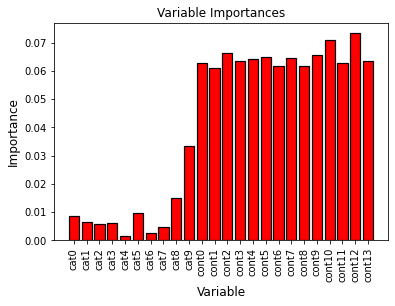

In [13]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

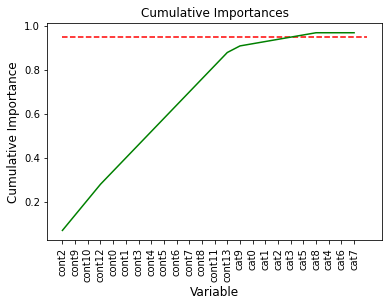

In [14]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

We can now use this to remove unimportant features. 95% is an arbitrary threshold, but if it leads to noticeably poor performance we can adjust the value. First, we need to find the exact number of features to exceed 95% importance:

In [15]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 19


In [16]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:18]]
# Create training and testing sets with only the important features
important_train_features = X_train[important_feature_names]
important_test_features = X_valid[important_feature_names]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (240000, 18)
Important test features shape: (60000, 18)


In [17]:
# Train the expanded model on only the important features
model_rf.fit(important_train_features, y_train);
# Make predictions on test data
new_predictions = model_rf.predict(important_test_features)
# Performance metrics
errors = mean_squared_error(y_valid, new_predictions, squared=False)
print('RMSE:', errors)
# Calculate rmse
rmse = np.mean(100 * (errors / y_valid))
# Calculate and display accuracy
accuracy = 100 - rmse
print('Accuracy:', round(accuracy, 2), '%.')

RMSE: 0.7318489423691498
Accuracy: 91.04 %.


In [18]:
# Train the model first on the original features
model_rf.fit(X_train, y_train);
# Make predictions on test data
predictions = model_rf.predict(X_valid)
# Performance metrics
errors = mean_squared_error(y_valid, predictions, squared=False)
print('Metrics for Random Forest Trained on original Data')
print('RMSE:', errors)
# Calculate rmse
rmse_new = np.mean(100 * (errors / y_valid))
# Calculate and display accuracy
accuracy = 100 - rmse_new
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on original Data
RMSE: 0.7315494616009549
Accuracy: 91.04 %.


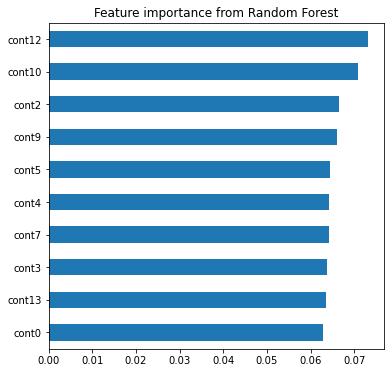

In [19]:
pd.Series(model_rf.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh',
                                                                               figsize = (6, 6),
                                                                              title = 'Feature importance from Random Forest').invert_yaxis();

In [20]:
xgb_params = {'objective': 'reg:squarederror',
              'n_estimators': 10000,
              'learning_rate': 0.25,
              'subsample': 0.926,
              'colsample_bytree': 0.84,
              'grow_policy':'lossguide',
              'max_depth': 2,
              'booster': 'gbtree', 
              'reg_lambda': 45.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'n_jobs': 4}

model_XGB = XGBRegressor(**xgb_params)
model_XGB.fit(X_train, y_train) 
predictions_XGB = model_XGB.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB, squared=False))

0.7183239111443006


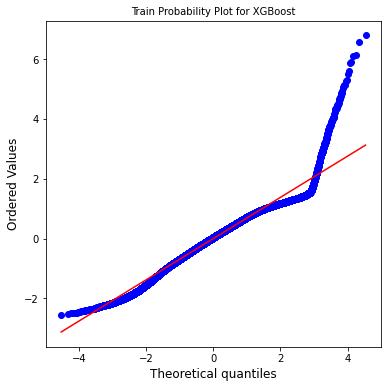

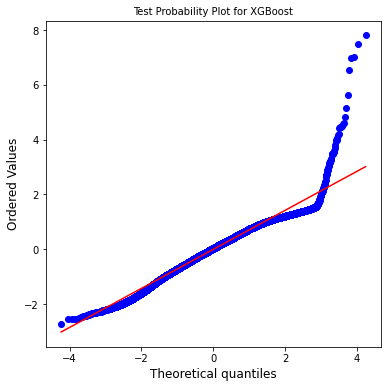

In [21]:
plt.rcParams["axes.labelsize"] = 12
xgb_prob_train = model_XGB.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(xgb_prob_train, plot=plt, fit=True)
plt.title('Train Probability Plot for XGBoost', fontsize=10)
plt.show()

xgb_prob_test = model_XGB.predict(X_valid) - y_valid
plt.figure(figsize=(6,6))
sp.stats.probplot(xgb_prob_test, plot=plt, fit=True)
plt.title('Test Probability Plot for XGBoost', fontsize=10)
plt.show()

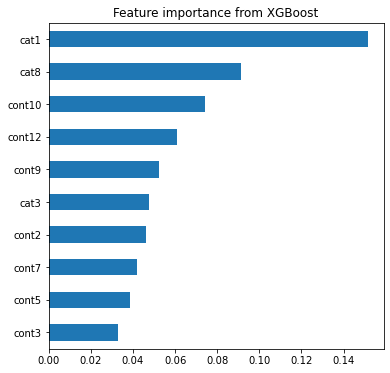

In [22]:
pd.Series(model_XGB.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh',
                                                                               figsize = (6, 6),
                                                                              title = 'Feature importance from XGBoost').invert_yaxis();


In [23]:
xgb_1_params = {
    'n_estimators': 5000,
    'learning_rate': 0.12,
    'subsample': 0.96,
    'colsample_bytree': 0.12,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 65.1,
    'reg_alpha': 15.9,
    'random_state':40
    }

model_XGB_1 = XGBRegressor(**xgb_1_params)
model_XGB_1.fit(X_train, y_train) 
predictions_XGB_1 = model_XGB_1.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_1, squared=False))

0.7159369602697875


In [24]:
xgb_2_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 5000,
    'learning_rate': 0.12,
    'subsample': 0.96,
    'colsample_bytree': 0.12,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 65.1,
    'reg_alpha': 15.9,
    'random_state':40
}

model_XGB_2 = XGBRegressor(**xgb_2_params)
model_XGB_2.fit(X_train, y_train) 
predictions_XGB_2 = model_XGB_2.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_2, squared=False))

0.7159369602697875


In [25]:
xgb_3_params = {
    'objective': 'reg:squarederror',
    "learning_rate" : 0.05,
    'n_estimators': 5000,
    "max_depth":12,
    "min_child_weight" :110,
    "gamma" :0.01,
    'booster': 'gbtree', 
    "subsample" : 0.7,
    "colsample_bytree" : 0.1,
    "reg_lambda" :65,
    "reg_alpha":71,
    "max_delta_step":10}

model_XGB_3 = XGBRegressor(**xgb_3_params)
model_XGB_3.fit(X_train, y_train) 
predictions_XGB_3 = model_XGB_3.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_3, squared=False))

0.7166146314498685


In [26]:
xgb_4_params = {
    'random_state': 1, 
    'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.03628302216953097,
    'reg_lambda': 0.0008746338866473539,
    'reg_alpha': 23.13181079976304,
    'subsample': 0.7875490025178415,
    'colsample_bytree': 0.11807135201147481,
    'max_depth': 3}

model_XGB_4 = XGBRegressor(**xgb_4_params)
model_XGB_4.fit(X_train, y_train) 
predictions_XGB_4 = model_XGB_4.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_4, squared=False))

0.7157119610099575


In [27]:
xgb_5_params = {'learning_rate': 0.07853392035787837, 
          'reg_lambda': 1.7549293092194938e-05, 
          'reg_alpha': 14.68267919457715, 
          'subsample': 0.8031450486786944, 
          'colsample_bytree': 0.170759104940733, 
          'max_depth': 3,
          'n_estimators': 5000
         }
model_XGB_5 = XGBRegressor(**xgb_5_params)
model_XGB_5.fit(X_train, y_train) 
predictions_XGB_5 = model_XGB_5.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_5, squared=False))

0.7164331275484737


In [29]:
lgbm_parameters = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'lambda_l1': 0.45,
    'lambda_l2': 4.8,
    'learning_rate': 0.005,
    'num_trees': 80000,
    'num_leaves': 10, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 1.0, 
    'bagging_freq': 0, 
    'min_child_samples': 100,
    'num_threads': 4
}

lgbm_model = LGBMRegressor(**lgbm_parameters)
lgbm_model.fit(X_train, y_train, eval_set = ((X_valid,y_valid)),verbose = -1, early_stopping_rounds = 1000,categorical_feature=cat_features) 
predictions_LGBM = lgbm_model.predict(X_valid)
print(mean_squared_error(y_valid, predictions_LGBM, squared=False))

[LightGBM] [Warning] num_iterations is set=80000, num_trees=80000 will be ignored. Current value: num_iterations=80000
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[34543]	valid_0's rmse: 0.718327
0.7183268257820973


In [30]:
lgbm_parameters_1 = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'reg_alpha': 0.4972562469417825, 
    'reg_lambda': 0.3273637203281044, 
    'num_leaves': 50, 
    'learning_rate': 0.032108486615557354,                      
    'max_depth': 40,                     
    'n_estimators': 4060, 
    'min_child_weight': 0.0173353329222102,
    'subsample': 0.9493343850444064, 
    'colsample_bytree': 0.5328221263825876, 
    'min_child_samples': 80
}

lgbm_model_1 = LGBMRegressor(**lgbm_parameters_1)
lgbm_model_1.fit(X_train, y_train, eval_set = ((X_valid,y_valid)),verbose = -1, early_stopping_rounds = 1000,categorical_feature=cat_features) 
predictions_LGBM_1 = lgbm_model_1.predict(X_valid)
print(mean_squared_error(y_valid, predictions_LGBM_1, squared=False))

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1481]	valid_0's rmse: 0.719918
0.7199178355503685


In [31]:
lgbm_parameters_2 = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'reg_alpha': 0.4994758073847213, 
    'reg_lambda': 0.32496035638807086, 
    'num_leaves': 55, 
    'learning_rate': 0.03292764050310852, 
    'max_depth': 32, 
    'n_estimators': 6059, 
    'min_child_weight': 0.018085927063358823, 
    'subsample': 0.9553223859131216, 
    'colsample_bytree': 0.5253243484788512, 
    'min_child_samples': 77
}

lgbm_model_2 = LGBMRegressor(**lgbm_parameters_2)
lgbm_model_2.fit(X_train, y_train, eval_set = ((X_valid,y_valid)),verbose = -1, early_stopping_rounds = 2000,categorical_feature=cat_features) 
predictions_LGBM_2 = lgbm_model_2.predict(X_valid)
print(mean_squared_error(y_valid, predictions_LGBM_2, squared=False))

Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[1208]	valid_0's rmse: 0.719881
0.7198805848572547


In [32]:
cat_parameters_1 = {    
    'iterations':1600,
    'learning_rate':0.024,
    'l2_leaf_reg':20,
    'random_strength':1.5,
    'grow_policy':'Depthwise',
    'leaf_estimation_method':'Newton', 
    'bootstrap_type':'Bernoulli',
    'thread_count':4,
    'verbose':False,
    'loss_function':'RMSE',
    'eval_metric':'RMSE',
    'od_type':'Iter'
}

cat_model_1 = CatBoostRegressor(**cat_parameters_1)
cat_model_1.fit(X_train, y_train, verbose =200) 
predictions_cat_1 = cat_model_1.predict(X_valid)
print(mean_squared_error(y_valid, predictions_cat_1, squared=False))

0:	learn: 0.7464904	total: 107ms	remaining: 2m 50s
200:	learn: 0.7308795	total: 7.82s	remaining: 54.4s
400:	learn: 0.7261869	total: 15.2s	remaining: 45.4s
600:	learn: 0.7214357	total: 22.4s	remaining: 37.2s
800:	learn: 0.7156556	total: 29.5s	remaining: 29.4s
1000:	learn: 0.7108888	total: 36.7s	remaining: 21.9s
1200:	learn: 0.7069343	total: 43.9s	remaining: 14.6s
1400:	learn: 0.7032917	total: 51.6s	remaining: 7.33s
1599:	learn: 0.6999247	total: 1m	remaining: 0us
0.7198383870414209


In [34]:
# Use the models to generate predictions
pred_1 = model_rf.predict(X_test)
pred_2 = model_XGB.predict(X_test)
pred_3 = model_XGB_1.predict(X_test)
pred_4 = model_XGB_2.predict(X_test)
pred_5 = model_XGB_3.predict(X_test)
pred_6 = model_XGB_4.predict(X_test)
pred_7 = model_XGB_5.predict(X_test)
pred_8 = lgbm_model.predict(X_test)
pred_9 = lgbm_model_1.predict(X_test)
pred_10= lgbm_model_2.predict(X_test)
pred_11 = cat_model_1.predict(X_test)

# Make sure to check that the weights sum up to ~1 by averaging the weights later 
preds = [pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7, pred_8, pred_9, pred_10, pred_11]
weights = [0., 1., 900., 900., 900., 5000., 1000., 90., 5., 1., 1.] 

sample_submission = pd.read_csv("../data/original/sample_submission.csv")
sample_submission.target = 0.0

for pred, weight in zip(preds, weights):
    sample_submission.target += weight * pred / sum(weights)

sample_submission.to_csv('../data/submit/009_submission.csv', index=False)